In [90]:
import pandas as pd

In [97]:
import offline_changepoint_detection as offcd
from functools import partial

In [98]:
Q, P, Pcp = offcd.offline_changepoint_detection(data, 
                                                partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

In [111]:
import online_changepoint_detection as oncd

In [123]:
data = np.arange(100) + np.random.normal(10, 5, 100)

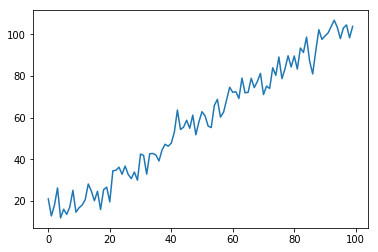

In [124]:
plt.plot(data)

In [125]:
R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

In [126]:
R.shape

(101, 101)

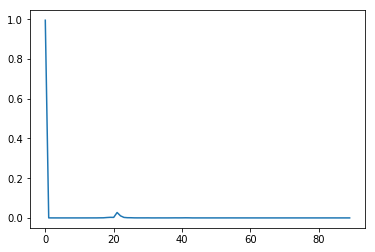

In [128]:
Nw=10;
plt.plot(R[Nw,Nw:-1])

In [119]:
def generate_univariate_time_series(num, minl=50, maxl=100):
    """Generate univariate normal time series.
    Args:
        num (int): Number of partitions
        minl (int): Minimum length of partition
        maxl (int): Maximum length of partition
    Returns:
        partition (int): Number of partitions
        data (np.array): Numpy array of data points
    """
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        std = np.random.randn()*1
        if std < 0:
            std *= -1
        tdata = np.random.normal(mean, std, p)
        data = np.concatenate((data, tdata))
    return partition, np.atleast_2d(data).T

In [120]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [121]:
partition, data = generate_univariate_time_series(3,15,30)

In [45]:
for i in range(23,45):
    data[i] +=i

(64, 1)

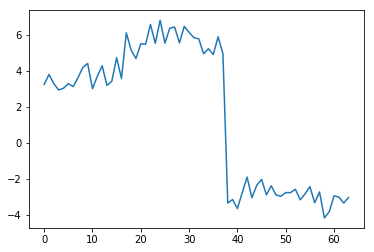

In [122]:
plt.plot(data)

In [ ]:
def divisive(tdata, sig_lvl=0.05, R=199, k=None, min_size=50, alpha=1):
    """Main method to divide a timeseries into segments.

    Args:
        tdata (np.ndarray): Numpy array for a multivariate time series.
                            Each row is a new observation at different time.
        sig_lvl (double):   Significance level required from the permutation test.
        R (int):            Number of iterations in the permutation test.
        k (int):            Number of segments to divide a timeseries into (optional).
        min_size(int):      Minimum size of each segment.
        alpha (int):        alpha value in the divergence measure.

    Returns:
        sol (dict):         Dictionary containing the estimated changepoints and other
                            auxiliary information from the algorithm.
    """
    assert not(R < 0 and k is None), "R must be a non-negative integer."
    assert not((sig_lvl <=0 or sig_lvl >= 1) and k is None), "sig_lvl must be a positive real number between 0 and 1."
    assert not(min_size < 2), "min_size must be an integer greater than 1."
    assert not(alpha > 2 or alpha <= 0), "alpha must be in (0,2]."

    n = len(tdata)
    global energy
    energy = np.zeros(shape=(n,2), dtype=np.float64)

    # If k is provided, no need to perform a permutation test.
    if k is None:
        k = n
    else:
        R = 0 #no need to perform a permutation test

    changes = np.array([0,n])
    sol = dict({'k_hat' : 1})
    pvals = np.array([])
    permutations = np.array([])

    D = pairwise_distances(tdata)
    condition = None

    while k > 0:
        #Find the split point
        tmp = split(changes, D, min_size, False)
        i = tmp['first']
        j = tmp['second']
        Estat = tmp['fourth']
        tmp = tmp['third']

        con = tmp[-1]
        if con == -1:
            break

        result = significance_test(D, R, changes, min_size, Estat)
        pval = result[0]
        permutations = np.append(permutations, result[1])
        pvals = np.append(pvals, pval)

        if pval > sig_lvl:
            break

        changes = tmp
        sol['k_hat'] += 1
        k -= 1

    # Update the return dictionary
    tmp = np.sort(changes)
    sol['order_found'] = changes
    sol['estimates'] = tmp
    sol['considered_last'] = con
    sol['p_values'] = pvals
    sol['permutations'] = permutations
    sol['clusters'] = np.array([], dtype=np.int32)

    current_cluster = 0
    i = 0
    for changepoint in sol['estimates']:
        while i < changepoint:
            sol['clusters'] = np.append(sol['clusters'], current_cluster)
            i += 1
        current_cluster += 1

    print( "Found {} split points".format(len(changes)-2))

    return sol

In [80]:
sig_lvl=0.05
R=100
alpha=1
min_size=10
k=None

In [81]:
n = len(data)

energy = np.zeros(shape=(n,2), dtype=np.float64)

# If k is provided, no need to perform a permutation test.
if k is None:
    k = n
else:
    R = 0 #no need to perform a permutation test
n,k, energy.shape

(64, 64, (64, 2))

In [82]:
changes = np.array([0,n])
sol = dict({'k_hat' : 1})
pvals = np.array([])
permutations = np.array([])

D = pairwise_distances(data)
condition = None
D.shape

(64, 64)

In [86]:
splits = np.sort(changes)
best = np.array([-1, -np.inf])
ii = -1
jj = -1
splits, best

(array([ 0, 64]), array([ -1., -inf]))

In [87]:
    for i in range(1,len(splits)):
        print('energy', energy[splits[i-1],0])
        if energy[splits[i-1],0]:
            tmp = np.copy(energy[splits[i-1],])
            print('if' , tmp)
        else:
            tmp = find_split_point(splits[i-1], splits[i]-1, D, min_size)
            energy[splits[i-1], 0] = tmp[0]
            energy[splits[i-1], 1] = tmp[1]
            print('else', tmp)

        if tmp[1] > best[1]:
            
            ii = splits[i-1]
            jj = splits[i]-1
            best = tmp
            print(ii, jj, best)

energy 0.0
else [ 45.         956.74052441]
0 63 [ 45.         956.74052441]


In [ ]:
    changes = np.append(changes, int(best[0]))
    energy[ii, 0] = 0
    energy[ii, 1] = 0

In [33]:
tmp = split(changes, D, min_size, False)
tmp

{'first': 0,
 'second': 51,
 'third': array([ 0, 52, 17]),
 'fourth': 457.4144561626539}

In [ ]:
while k > 0:
    #Find the split point
    tmp = split(changes, D, min_size, False)
    i = tmp['first']
    j = tmp['second']
    Estat = tmp['fourth']
    tmp = tmp['third']

    con = tmp[-1]
    if con == -1:
        break

    result = significance_test(D, R, changes, min_size, Estat)
    pval = result[0]
    permutations = np.append(permutations, result[1])
    pvals = np.append(pvals, pval)

    if pval > sig_lvl:
        break

    changes = tmp
    sol['k_hat'] += 1
    k -= 1

# Update the return dictionary
tmp = np.sort(changes)
sol['order_found'] = changes
sol['estimates'] = tmp
sol['considered_last'] = con
sol['p_values'] = pvals
sol['permutations'] = permutations
sol['clusters'] = np.array([], dtype=np.int32)

current_cluster = 0
i = 0
for changepoint in sol['estimates']:
    while i < changepoint:
        sol['clusters'] = np.append(sol['clusters'], current_cluster)
        i += 1
    current_cluster += 1

print( "Found {} split points".format(len(changes)-2))

## Check

In [74]:
sol = divisive(data, sig_lvl=0.05, R=100, alpha=1, min_size=10)

Found 4 split points


In [75]:
print( "Changepoints found are {}".format(sol['estimates'][1:]))

Changepoints found are [10 21 35 45 64]


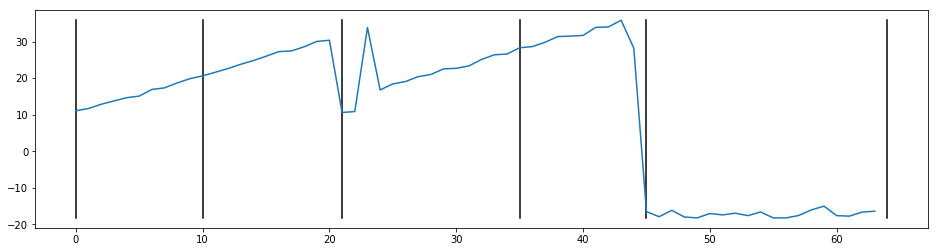

In [76]:
fig, ax = plt.subplots(figsize=[16,4])
for p in sol['estimates']:
    ax.plot([p,p], [np.min(data),np.max(data)],'black')
for d in range(1):
    ax.plot(data[:,d])